In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
names = ['Size', '#Threads', 'Runtime (s)', 'Energy (J)']
df = pd.read_csv('matmul_cn128_pinned.csv', names=names, usecols=[0, 1, 3, 5])

#names = ['Size', '#Threads', 'Runtime (s)', 'Energy (J)']
#df = pd.read_csv('matmul_rust.csv', names=names, usecols=[0, 1, 2, 4])

flop = df['Size'] * df['Size'] * (2 * df['Size'] - 1)
df['GFLOP/s'] = flop / df['Runtime (s)'] / 1e9
df['GFLOP/J'] = flop / df['Energy (J)'] / 1e9

df

,Size,#Threads,Runtime (s),Energy (J),GFLOP/s,GFLOP/J
0,300,1,0.030794,0.484899,1.750662,0.111178
1,300,2,0.025826,0.428109,2.087438,0.125926
2,300,3,0.017505,0.349451,3.079684,0.154271
3,300,4,0.013395,0.281137,4.024626,0.191757
4,300,5,0.011329,0.278599,4.758462,0.193504
...,...,...,...,...,...,...
219,1600,12,4.354133,149.080179,1.880843,0.054933
220,1600,13,3.966372,149.202763,2.064718,0.054888
221,1600,14,3.700477,140.141552,2.213077,0.058437
222,1600,15,3.486829,144.103696,2.348679,0.056830


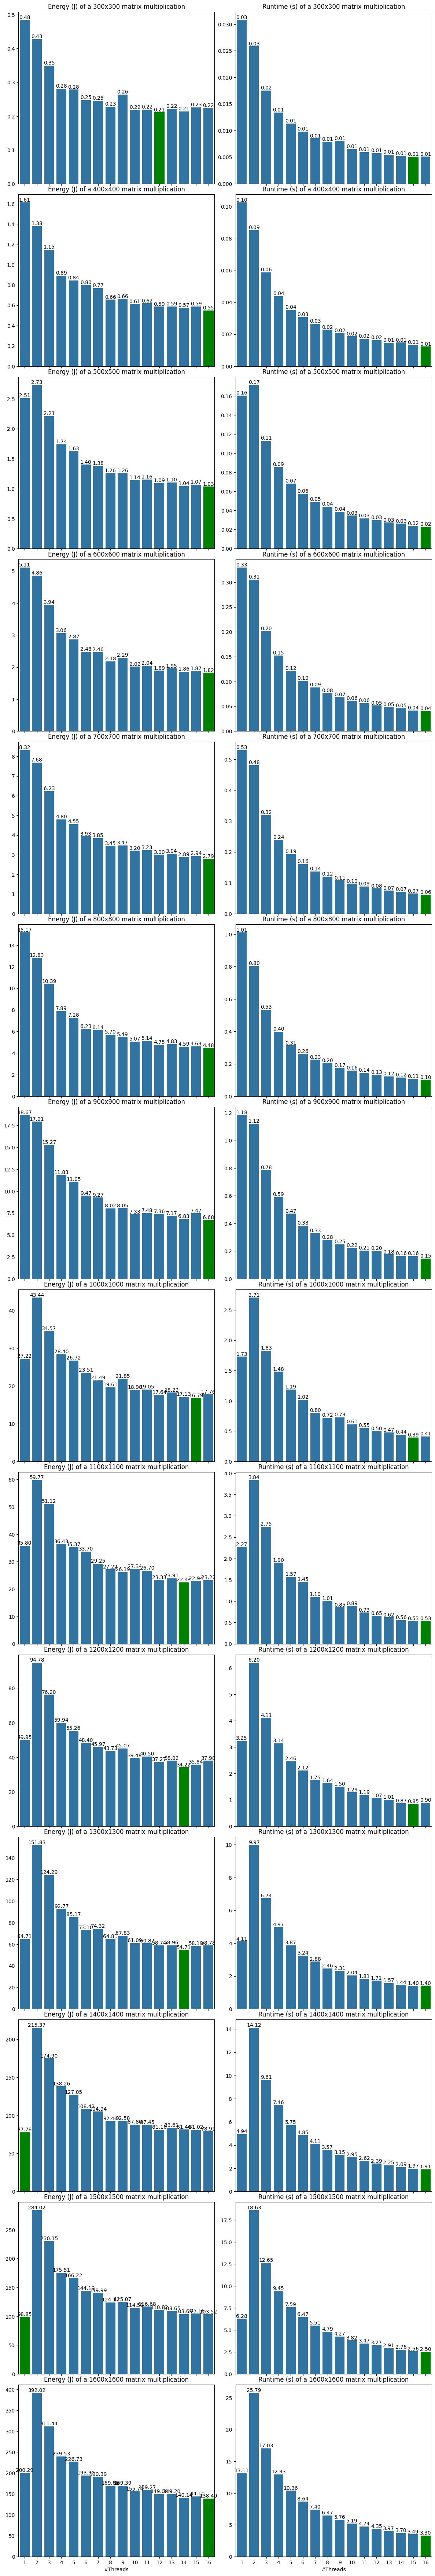

In [36]:
by_size = df.groupby('Size')

fig, axs = plt.subplots(len(by_size), 2, figsize=(12, 5 * len(by_size)), sharex=True)
fig.tight_layout()

for ((size, dfx), (ax_j, ax_s)) in zip(df.groupby('Size'), axs):
    sns.barplot(dfx, x='#Threads', y='Energy (J)', ax=ax_j)
    sns.barplot(dfx, x='#Threads', y='Runtime (s)', ax=ax_s)

    ax_j.set_title(f'Energy (J) of a {size}x{size} matrix multiplication')
    ax_s.set_title(f'Runtime (s) of a {size}x{size} matrix multiplication')
    ax_j.set_ylabel('')
    ax_s.set_ylabel('')
    
    def color_best(ax, col):
        ax.bar_label(ax.containers[0], fmt='%.2f')
        for bar in ax.patches:
            if bar.get_height() == dfx[col].min():
                bar.set_color('g')
                return
    color_best(ax_j, 'Energy (J)')
    color_best(ax_s, 'Runtime (s)')

plt.show()

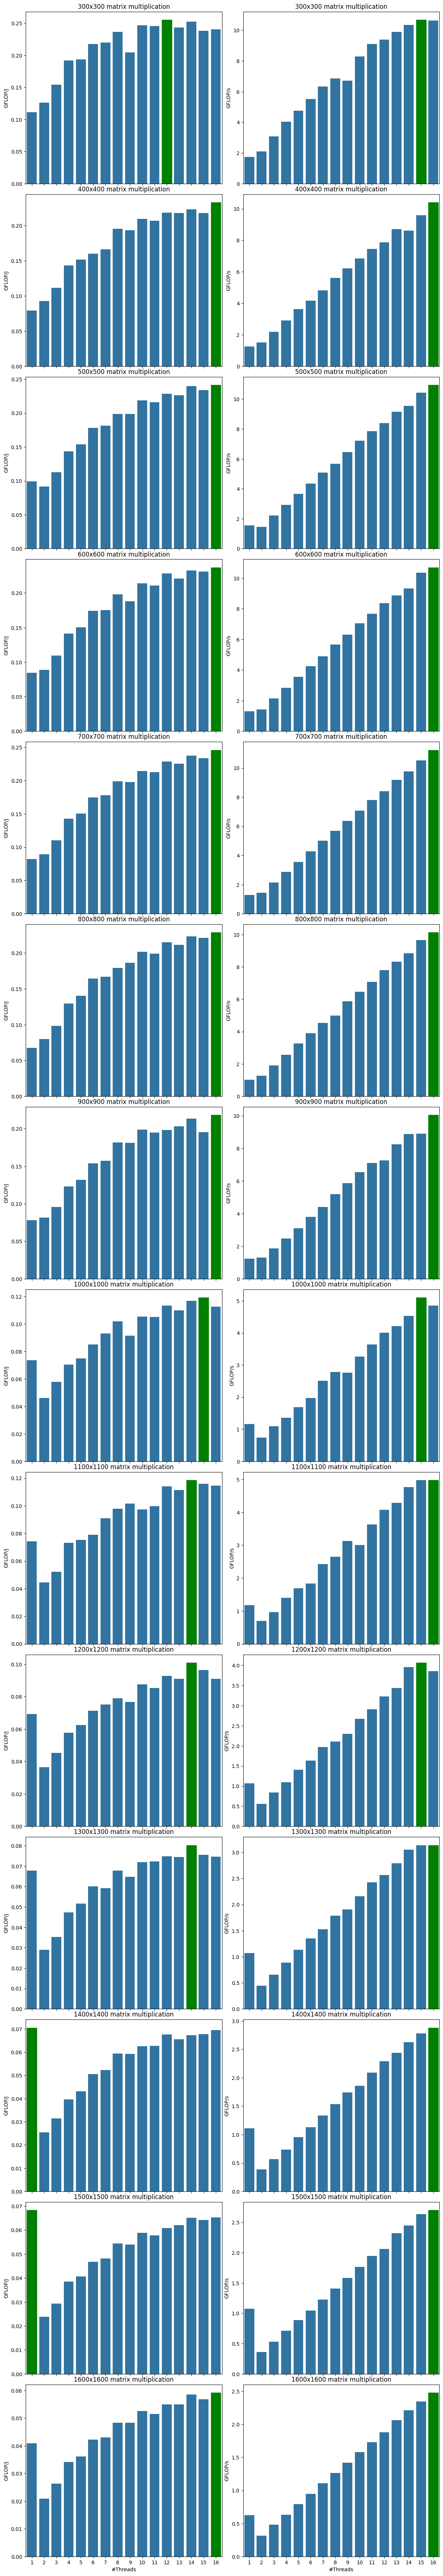

In [37]:
by_size = df.groupby('Size')

fig, axs = plt.subplots(len(by_size), 2, figsize=(12, 5 * len(by_size)), sharex=True)
fig.tight_layout()

for ((size, dfx), (ax_j, ax_s)) in zip(df.groupby('Size'), axs):
    sns.barplot(dfx, x='#Threads', y='GFLOP/J', ax=ax_j)
    sns.barplot(dfx, x='#Threads', y='GFLOP/s', ax=ax_s)

    ax_j.set_title(f'{size}x{size} matrix multiplication')
    ax_s.set_title(f'{size}x{size} matrix multiplication')
    
    def color_best(ax, col):
        for bar in ax.patches:
            if bar.get_height() == dfx[col].max():
                bar.set_color('g')
                return
    color_best(ax_j, 'GFLOP/J')
    color_best(ax_s, 'GFLOP/s')

plt.show()

In [1]:
import tikzplotlib

#tikzplotlib.clean_figure()
#tikzplotlib.save("test.tex")

ImportError: cannot import name 'common_texification' from 'matplotlib.backends.backend_pgf' (/home/jordy/pyenv/lib/python3.12/site-packages/matplotlib/backends/backend_pgf.py)